In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
from xgboost import XGBRegressor, XGBRFRegressor

In [23]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [24]:
from sklearn.ensemble import VotingRegressor, StackingRegressor, ExtraTreesRegressor

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train.sample(10)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
12975,45791297,17876,-,TOYOTA,Prius,2011,Sedan,No,Hybrid,1.8,15000 km,4,Automatic,Front,4-May,Left wheel,Red,12
15826,45803277,10036,639,HYUNDAI,Sonata,2014,Sedan,Yes,LPG,2,268046 km,4,Automatic,Front,4-May,Left wheel,Silver,4
698,45776738,22423,-,BMW,128 M tech,2013,Cabriolet,Yes,Petrol,3,67646 km,6,Manual,Front,4-May,Left wheel,Black,8
9464,45797718,22433,779,HYUNDAI,H1,2013,Minivan,Yes,Diesel,2.5,69315 km,4,Automatic,Front,4-May,Left wheel,Black,4
5883,45770184,1882,1053,MERCEDES-BENZ,E 350,2014,Sedan,Yes,Petrol,3.5,146395 km,6,Automatic,Rear,4-May,Left wheel,Grey,12
7082,45808748,1176,779,FORD,Escape,2013,Jeep,Yes,Petrol,2.5,241638 km,4,Automatic,Front,4-May,Left wheel,Silver,12
13130,45509281,17249,-,TOYOTA,Prius,2009,Sedan,No,Hybrid,1.8,380800 km,4,Variator,Front,4-May,Left wheel,Black,8
18458,45761256,314,259,CHEVROLET,Volt,2014,Hatchback,Yes,Hybrid,1.4,131893 km,4,Automatic,Front,4-May,Left wheel,Brown,0
9372,45797692,15063,1024,HYUNDAI,H1,2010,Minivan,Yes,Diesel,2.5,52717 km,4,Automatic,Front,4-May,Left wheel,Black,4
8126,45629200,2666,382,FORD,Fusion,2015,Sedan,Yes,Hybrid,2,100747 km,4,Automatic,Front,4-May,Left wheel,Green,0


In [27]:
train['logPrice'] = np.log(train.Price)

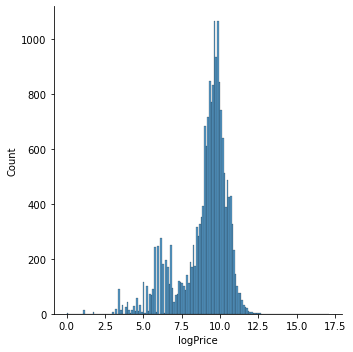

In [28]:
sns.displot(train.logPrice)

In [29]:
lowPrice = np.quantile(train.logPrice, 0.02)
highPrice = np.quantile(train.logPrice, 0.99)
print (lowPrice, highPrice)

4.700480365792417 11.346575677685973


<AxesSubplot:xlabel='cappedLogPrice', ylabel='Count'>

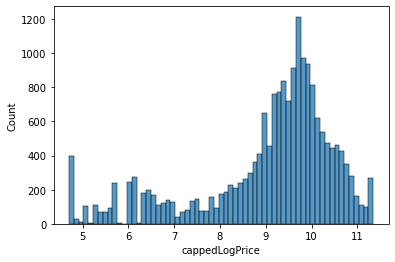

In [30]:
train['cappedLogPrice'] = train.logPrice
train.loc[train.logPrice < lowPrice, 'cappedLogPrice'] = lowPrice
train.loc[train.logPrice > highPrice, 'cappedLogPrice'] = highPrice
sns.histplot(train.cappedLogPrice)

<AxesSubplot:xlabel='cappedLogPrice'>

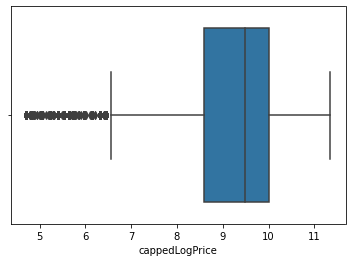

In [31]:
sns.boxplot(train.cappedLogPrice)

In [32]:
df_train = train.drop(columns=['ID', 'Price', 'logPrice'])

In [33]:
df_train.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,cappedLogPrice
0,-,GAZ,20,1953,Sedan,No,Petrol,2,0 km,4,Manual,Rear,4-May,Left wheel,Beige,0,10.854102
1,-,GAZ,20,1953,Jeep,No,Petrol,3.2,100000 km,4,Manual,4x4,2-Mar,Left wheel,Green,0,8.070906
2,-,GAZ,21,1964,Sedan,No,Petrol,2.4,0 km,4,Manual,Rear,4-May,Left wheel,Sky blue,0,8.966994
3,-,GAZ,24,1990,Universal,Yes,Petrol,6.3,2000 km,8,Manual,4x4,2-Mar,Left wheel,Green,0,8.581294
4,-,AUDI,50,2018,Coupe,Yes,Petrol,0.5,4000 km,1,Tiptronic,Rear,>5,Right-hand drive,Blue,0,7.170120


In [34]:
cat_cols = ['Category', 'Leather interior', 'Fuel type',
           'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']
num_cols = ['Levy', 'Prod. year', 'Engine volume', 
            'Airbags', 'Cylinders', 'Mileage']
print (len(df_train.columns.to_list()), 
        len(cat_cols),
        len(num_cols))

17 8 6


In [35]:
sorted(train.Doors.unique())

['2-Mar', '4-May', '>5']

## Mileage

In [36]:
#m = np.exp(df_train[['Mileage']])
#m.loc[m.Mileage > np.quantile(m.Mileage, 0.99), 'Mileage'] = np.quantile(m.Mileage, 0.99)
#m.Mileage.fillna(m.Mileage.median())
#sns.boxplot(m.Mileage)

In [38]:
#sns.boxplot(df_train.Mileage)

In [39]:
df_train.loc[df_train.Levy=='-', 'Levy'] = 0
df_train.Mileage = train.Mileage.apply(lambda x: int(x[:-3]))
df_train.loc[df_train.Mileage==0, 'Mileage'] = None

In [44]:
df_train['Mileage'] = df_train['Mileage'].\
                        fillna(df_train.groupby('Prod. year')['Mileage'].transform('median'))
df_train.Mileage.fillna(df_train.Mileage.mean(), inplace=True)
#df_train.Mileage = np.log(df_train.Mileage)
up_mileage = np.quantile(df_train.Mileage, 0.99)
df_train.loc[df_train.Mileage > up_mileage, 'Mileage'] = up_mileage

In [45]:
df_train[num_cols].head()

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage
0,0,1953,2,0,4,150000.0
1,0,1953,3.2,0,4,100000.0
2,0,1964,2.4,0,4,50000.0
3,0,1990,6.3,0,8,2000.0
4,0,2018,0.5,0,1,4000.0


In [46]:
df_train.Levy = df_train.Levy.astype(int)

In [47]:
df_train['Engine volume'] = df_train['Engine volume'].apply(lambda x: float(x.split(' ')[0]))
df_train['Engine volume'] = df_train['Engine volume'].astype(float)

In [48]:
df_dummies = pd.get_dummies(df_train[cat_cols], drop_first=True)
df_dummies.tail()

,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,Category_Sedan,Category_Universal,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
19232,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19233,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
19234,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19235,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19236,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Feature Engineering

In [49]:
print (np.quantile(df_train.Mileage, 0.1), np.quantile(df_train['Prod. year'], 0.1))

37960.000000000015 2003.0


<AxesSubplot:xlabel='Prod. year'>

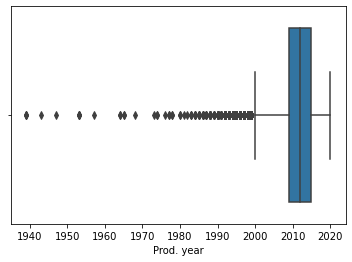

In [50]:
sns.boxplot(df_train['Prod. year'])

In [51]:
df_train['KMPerYear'] = np.log(df_train.Mileage / (2021 - df_train['Prod. year']))
if not 'KMPerYear' in num_cols:
    num_cols.append('KMPerYear')        

In [52]:
np.quantile(df_train.KMPerYear, 0.02)

6.7499477435394475

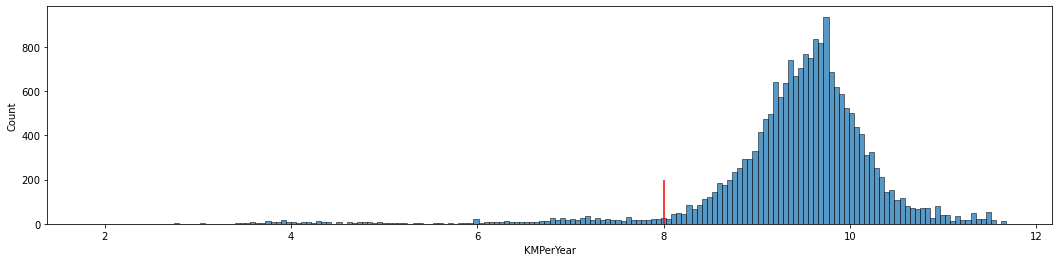

In [53]:
plt.figure(figsize=(18, 4))
sns.histplot(df_train.KMPerYear)
plt.vlines(8, ymin=0, ymax=200, colors='r')

In [54]:
df_train['Rare'] = ((df_train['Prod. year']<2000) & (df_train.KMPerYear<8) | (df_train.KMPerYear>12.5))
if not ('Rare' in num_cols):
    num_cols.append('Rare')

In [55]:
df_train.Rare.value_counts()

False    19036
True       201
Name: Rare, dtype: int64

In [56]:
df_train['isTurbo'] = train['Engine volume'].apply(lambda x: x.split(' ')[-1]=='Turbo')
if not 'isTurbo' in num_cols:
    num_cols.append('isTurbo')

In [57]:
df_train[num_cols].sample(5)

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage,KMPerYear,Rare,isTurbo
16099,891,2016,2.0,4,4,295509.0,10.987017,False,False
10002,1750,2008,3.3,12,6,190000.0,9.589830,False,False
15342,891,2016,2.0,4,4,136663.0,10.215835,False,False
8967,1363,2012,4.6,0,8,150909.0,9.727208,False,False
11580,1850,2008,3.5,12,6,366869.0,10.247811,False,False


<AxesSubplot:xlabel='ft1', ylabel='Count'>

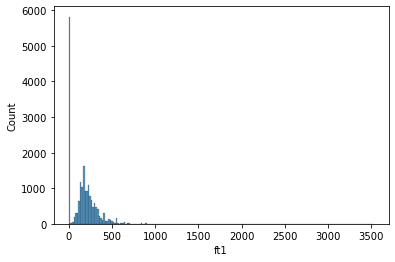

In [58]:
df_train['ft1'] = np.sqrt(df_train.Levy) * (2021 - df_train['Prod. year'])
if not 'ft1' in num_cols:
    num_cols.append('ft1')
sns.histplot(df_train.ft1)

<AxesSubplot:xlabel='ft2', ylabel='Count'>

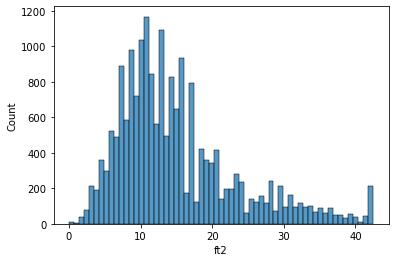

In [59]:
df_train['ft2'] = np.sqrt(df_train['Engine volume']) * (2021 - df_train['Prod. year'])
df_train.loc[df_train.ft2 > np.quantile(df_train.ft2, 0.99), 'ft2'] =  np.quantile(df_train.ft2, 0.99)
if not 'ft2' in num_cols:
    num_cols.append('ft2')
sns.histplot(df_train.ft2)

<AxesSubplot:xlabel='ft3', ylabel='Count'>

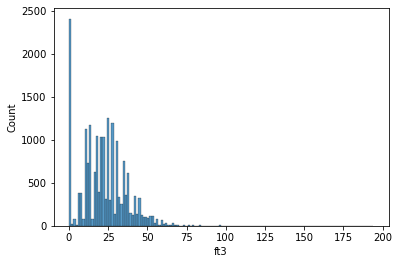

In [60]:
df_train['ft3'] = np.sqrt(df_train['Airbags']) * (2021 - df_train['Prod. year'])
if not 'ft3' in num_cols:
    num_cols.append('ft3')
sns.histplot(df_train.ft3)

In [61]:
num_cols.remove('ft2')

# Base N Encoding

In [62]:
import category_encoders as ce

### Manufacturer

In [63]:
manf_encoder = ce.BaseNEncoder(cols=['Manufacturer'], return_df = True, base=4)
manf_encoder.fit(df_train[['Manufacturer']])
manf_df = manf_encoder.transform((df_train[['Manufacturer']]))
manf_df.sample(5)

,Manufacturer_0,Manufacturer_1,Manufacturer_2,Manufacturer_3,Manufacturer_4
4776,0,0,1,0,0
1697,0,0,1,1,2
9936,0,0,1,1,2
13020,0,0,1,1,2
11568,0,0,0,1,1


### Model Name

In [64]:
df_train['ModelName'] = df_train.Model.apply(lambda x: x.split(' ')[0])
df_train.loc[df_train.ModelName.apply(lambda x : x.isnumeric()), 'ModelName'] = 'Others'
df_train.loc[df_train.ModelName.apply(lambda x : '+' in x), 'ModelName'] = 'Others'

In [65]:
name_encoder = ce.BaseNEncoder(cols=['ModelName'], return_df = True, base=6)
name_encoder.fit(df_train[['ModelName']])
model_df = name_encoder.transform((df_train[['ModelName']]))
model_df.sample(5)

,ModelName_0,ModelName_1,ModelName_2,ModelName_3,ModelName_4
7141,0,0,4,2,1
6236,0,0,4,0,1
2831,0,0,1,5,2
6898,0,0,4,0,1
12583,0,1,3,3,2


# Modelling

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = pd.concat([df_train[num_cols], df_dummies, model_df, manf_df], axis=1)
y = df_train.cappedLogPrice
#y = train.logPrice
X_cols = X.columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X[X_cols], y, 
                                                    test_size = 0.2, random_state = 42,
                                                    stratify = df_train.Airbags)
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_cols)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_cols)
X_train.head()

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage,KMPerYear,Rare,isTurbo,ft1,...,ModelName_0,ModelName_1,ModelName_2,ModelName_3,ModelName_4,Manufacturer_0,Manufacturer_1,Manufacturer_2,Manufacturer_3,Manufacturer_4
16814,753,2012,2.4,12,4,152466.0,9.737472,False,False,246.967609,...,0,2,0,0,5,0,0,1,3,3
17495,0,2004,1.8,2,4,223000.0,9.481714,False,False,0.000000,...,0,2,0,5,5,0,0,2,0,3
4310,891,2016,2.0,12,4,59408.0,9.382746,False,False,149.248116,...,0,0,2,5,4,0,0,2,2,2
1935,1518,2003,1.8,4,4,23450.0,7.172254,False,False,701.307351,...,0,0,0,5,4,0,0,1,3,0
15285,1079,2018,2.0,4,4,69000.0,10.043249,False,False,98.544406,...,0,1,5,1,5,0,0,1,2,1


# Random Forest

In [67]:
rf_best = RandomForestRegressor(bootstrap=False, max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133).fit(X_train_scaled, y_train)
print (rf_best.score(X_train_scaled, y_train), rf_best.score(X_test_scaled, y_test))

0.9554427399635642 0.7252552484929253


In [74]:
rf_prod = RandomForestRegressor(bootstrap=False, max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133).fit(X[X_cols], y)

In [68]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(
        np.exp(y_test), 
        np.exp(rf_best.predict(X_test_scaled))))

0.7970917058644738

In [69]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(
        np.exp(y_train), 
        np.exp(rf_best.predict(X_train_scaled))))

0.3196244949786703

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

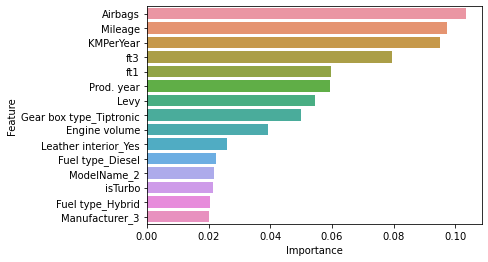

In [116]:
df_importance = pd.DataFrame(rf_best.feature_importances_, columns = ['Importance'])
df_importance['Feature'] = X_cols
df_importance = df_importance[['Feature', 'Importance']].sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=df_importance.head(15))

---


# XGBoost

In [131]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()
    gsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train_scaled,y_train)

    return gsearch.best_params_
#hyperParameterTuning(X_train_scaled, y_train)

In [132]:
xg_model = XGBRegressor(subsample= 0.5,
 objective= 'reg:squarederror',
 n_estimators= 500,
 min_child_weight= 1,
 max_depth= 10,
 learning_rate= 0.1,
 colsample_bytree= 0.5).fit(X_train_scaled, y_train)

print (xg_model.score(X_test_scaled, y_test))

0.6964697425906154


# Ensemble - Stack Regression and Voting

In [70]:
ens_rf = RandomForestRegressor(bootstrap=False, max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133)
ens_xg = XGBRegressor(subsample= 0.5, objective= 'reg:squarederror', n_estimators= 500, min_child_weight= 1,
                      max_depth= 10, learning_rate= 0.1, colsample_bytree= 0.5)
ens_ext = ExtraTreesRegressor(max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133)

vot_model = VotingRegressor([('rf', ens_rf), ('xg', ens_xg), ('ext', ens_ext)])
vot_model.fit(X_train_scaled, y_train)
vot_model.score(X_test_scaled, y_test)

0.724110313340773

In [71]:
np.sqrt(mean_squared_log_error(
        np.exp(y_test), 
        np.exp(vot_model.predict(X_test_scaled))))

0.7987639685951297

In [155]:
np.sqrt(mean_squared_log_error(
        np.exp(y_train), 
        np.exp(vot_model.predict(X_train_scaled))))

0.30181126739014574

In [72]:
ext_model = ExtraTreesRegressor(max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133)
ext_model.fit(X_train_scaled, y_train)
ext_model.score(X_test_scaled, y_test)

0.7059790626667407

---

In [75]:
df_test = test.drop(columns = 'ID')

df_test.loc[df_test.Levy=='-', 'Levy'] = 0
df_test.loc[df_test.Doors=='04-May', 'Doors'] = '4-May'
df_test.loc[df_test.Doors=='02-Mar', 'Doors'] = '2-Mar'

df_test.Mileage = df_test.Mileage.apply(lambda x: int(x[:-3]))
df_test.loc[df_test.Mileage==0, 'Mileage'] = None
df_test['Mileage'] = df_test['Mileage'].\
                        fillna(df_test.groupby('Prod. year')['Mileage'].transform('median'))
df_test.Mileage.fillna(df_test.Mileage.mean(), inplace=True)

df_test['Engine volume'].apply(lambda x: float(x.split(' ')[0]))
df_test['Engine volume'] = df_test['Engine volume'].apply(lambda x: float(x.split(' ')[0]))

df_test.Levy = df_test.Levy.astype(int)
df_test.loc[df_test.Cylinders > 15, 'Cylinders'] = 15

df_dummies_test = pd.get_dummies(df_test[cat_cols], drop_first=True)

df_test['KMPerYear'] = np.log((df_test.Mileage) / (2021 - df_test['Prod. year']))

df_test['Rare'] = ((df_test['Prod. year']<2000) & (df_test.KMPerYear<8) | (df_test.KMPerYear>12.5))
df_test['isTurbo'] = test['Engine volume'].apply(lambda x: x.split(' ')[-1]=='Turbo')

df_test['ft1'] = np.sqrt(df_test.Levy) * (2021 - df_test['Prod. year'])
#df_test['ft2'] = np.sqrt(df_test['Engine volume']) * (2021 - df_test['Prod. year'])
df_test['ft3'] = np.sqrt(df_test['Airbags']) * (2021 - df_test['Prod. year'])

df_test['ModelName'] = df_test.Model.apply(lambda x: x.split(' ')[0])
df_test.loc[df_test.ModelName.apply(lambda x : x.isnumeric()), 'ModelName'] = 'Others'
df_test.loc[df_test.ModelName.apply(lambda x : '+' in x), 'ModelName'] = 'Others'

model_df_test = name_encoder.transform(df_test['ModelName'])
manf_df_test = manf_encoder.transform(df_test['Manufacturer'])

#############################################

X_submit = pd.concat([df_test[num_cols], df_dummies_test, model_df_test, manf_df_test], axis=1)
X_submit_scaled = pd.DataFrame(scaler.transform(X_submit), columns=X_cols)
X_submit_scaled.head()

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage,KMPerYear,Rare,isTurbo,ft1,...,ModelName_0,ModelName_1,ModelName_2,ModelName_3,ModelName_4,Manufacturer_0,Manufacturer_1,Manufacturer_2,Manufacturer_3,Manufacturer_4
0,-1.111501,0.195164,-0.349990,0.791105,-0.483287,-0.019847,0.281132,-0.105689,2.995568,-1.040142,...,0.0,-0.952072,1.538404,1.125706,-1.478144,0.0,-0.008061,0.057415,-0.261412,-1.468745
1,-1.111501,0.195164,0.110933,0.791105,-0.483287,-1.219124,-1.583440,-0.105689,-0.333826,-1.040142,...,0.0,0.482234,1.538404,1.125706,1.445054,0.0,-0.008061,0.057415,0.780243,-0.446700
2,-1.111501,-1.026999,-0.926144,0.328159,-0.483287,0.224074,-0.177695,-0.105689,-0.333826,-1.040142,...,0.0,1.916541,-1.331163,0.622028,0.275775,0.0,-0.008061,0.057415,-1.303068,1.597389
3,0.600847,0.195164,1.032778,1.254051,1.190838,-0.030010,0.273541,-0.105689,-0.333826,0.734690,...,0.0,1.916541,-0.183336,-0.889005,-0.308865,0.0,-0.008061,-1.560818,1.821899,0.575344
4,-1.111501,-3.122136,-0.810913,-1.523624,-0.483287,0.549302,-0.597361,-0.105689,-0.333826,-1.040142,...,0.0,-0.952072,-1.331163,1.125706,0.860415,0.0,-0.008061,0.057415,1.821899,-1.468745


In [76]:
y_submit = pd.DataFrame(np.round(np.exp(rf_prod.predict(X_submit_scaled)), 2) , columns=['Price'])
y_submit.to_csv('submission.csv', index=False)

In [156]:
y_submit = pd.DataFrame(np.round(np.exp(vot_model.predict(X_submit_scaled)), 2) , columns=['Price'])
y_submit.to_csv('submission.csv', index=False)

<AxesSubplot:xlabel='Airbags'>

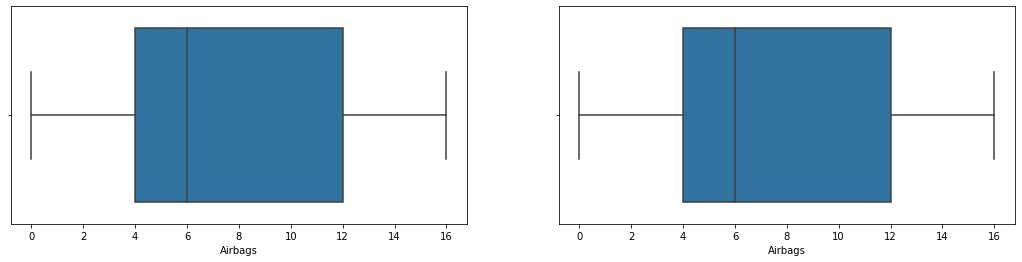

In [118]:
plt.figure(figsize=(18, 4))

plt.subplot(121); sns.boxplot(df_train.Airbags)
plt.subplot(122); sns.boxplot(df_test.Airbags)
